In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv1D
from keras.models import Sequential
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [16]:
df = pd.DataFrame(loadmat('data/Xtrain.mat')['Xtrain'])

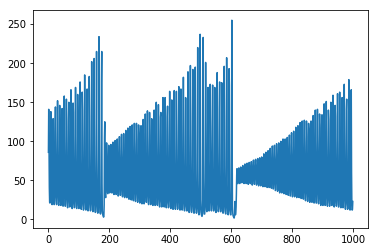

In [17]:
dataset = df.values
dataset = df.astype('float32')
plt.plot(dataset ) # plotting t, a separately 
plt.show()

In [18]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)

/home/adrigrillo/Apps/conda/envs/dl/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [20]:

# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

800 200


In [21]:

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [26]:
# reshape into X=t and Y=t+1
look_back = 100
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [27]:
# reshape input to be [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[1],1))
testX = np.reshape(testX, (testX.shape[0],  testX.shape[1],1))

print(trainX.shape) #channels_last

(699, 100, 1)


In [28]:

# define model
model = Sequential()
model.add(Conv1D(filters=4, kernel_size=10, activation='relu', input_shape=(look_back,1)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(trainX, trainY, epochs=10, verbose=2)

Epoch 1/10
 - 1s - loss: 0.2740
Epoch 2/10
 - 0s - loss: 0.1532
Epoch 3/10
 - 0s - loss: 0.1136
Epoch 4/10
 - 0s - loss: 0.0910
Epoch 5/10
 - 0s - loss: 0.0763
Epoch 6/10
 - 0s - loss: 0.0677
Epoch 7/10
 - 0s - loss: 0.0619
Epoch 8/10
 - 0s - loss: 0.0568
Epoch 9/10
 - 0s - loss: 0.0545
Epoch 10/10
 - 0s - loss: 0.0525


In [25]:
# make predictions
trainPredict = model.predict(np.reshape(trainX[0], newshape=(1,100,1)))
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

ValueError: Found input variables with inconsistent numbers of samples: [699, 1]

In [ ]:
model.summary()

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()